# Using PyTorch for simple regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/2.pytorch-nn-training-cars.ipynb)

## Support code

In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def carshow(m, b, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    
    plt.show()

def mshow(model, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

## Load simple data set

In [3]:
df_cars = pd.read_csv("data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [4]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Pytorch built-in linear model

Epoch   0 MSE loss      576.468 MAE    22.58
Epoch  10 MSE loss      184.361 MAE    12.79
Epoch  20 MSE loss       39.454 MAE     5.03
Epoch  30 MSE loss       20.595 MAE     3.55
Epoch  40 MSE loss       24.551 MAE     4.06
Epoch  50 MSE loss       21.011 MAE     3.65
Epoch  60 MSE loss       18.759 MAE     3.28
Epoch  70 MSE loss       18.907 MAE     3.28
LAST      MSE loss       18.907 MAE     3.28


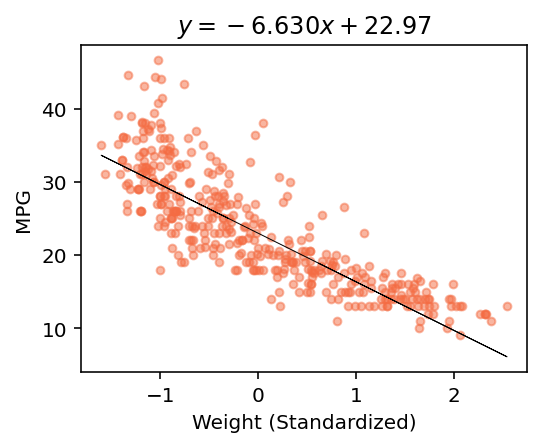

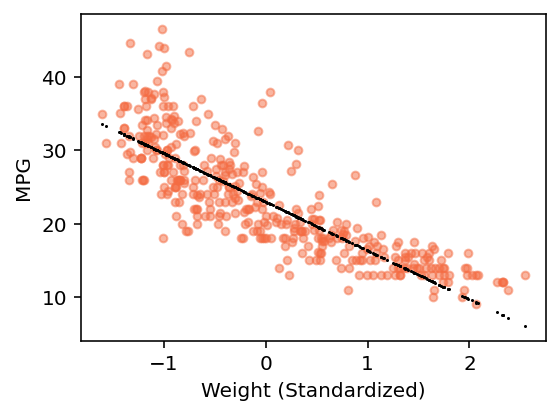

In [5]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)
mshow(model, X=X, y=df_cars.MPG)

## Factor out a training method

In [6]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

Epoch    0 MSE loss      599.259 MAE    23.18
Epoch    7 MSE loss      282.736 MAE    16.25
Epoch   14 MSE loss      119.212 MAE     9.80
Epoch   21 MSE loss       36.848 MAE     4.81
Epoch   28 MSE loss       19.843 MAE     3.30
Epoch   35 MSE loss       22.348 MAE     3.83
Epoch   42 MSE loss       24.475 MAE     4.03
Epoch   49 MSE loss       21.848 MAE     3.75
Epoch   56 MSE loss       19.401 MAE     3.42
Epoch   63 MSE loss       18.678 MAE     3.27
Epoch   70 MSE loss       18.861 MAE     3.29
LAST       MSE loss       18.861 MAE     3.29


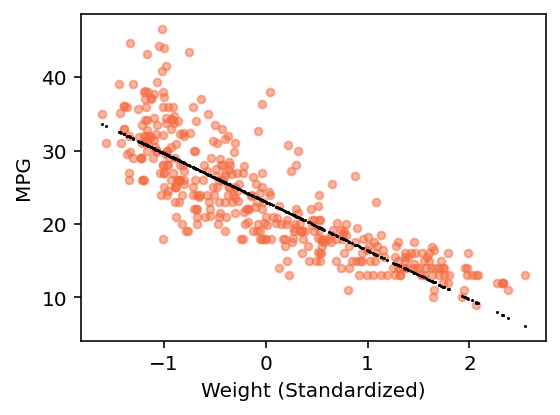

In [7]:
model = nn.Linear(1, 1)

train(model, learning_rate=1, nepochs=70)

mshow(model, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

### Without nonlinearity

Epoch    0 MSE loss      609.804 MAE    23.42
Epoch   10 MSE loss       27.217 MAE     4.32
Epoch   20 MSE loss       70.748 MAE     7.12
Epoch   30 MSE loss       20.684 MAE     3.60
Epoch   40 MSE loss       21.529 MAE     3.33
Epoch   50 MSE loss       19.074 MAE     3.36
Epoch   60 MSE loss       18.692 MAE     3.27
Epoch   70 MSE loss       18.679 MAE     3.28
Epoch   80 MSE loss       18.683 MAE     3.29
Epoch   90 MSE loss       18.686 MAE     3.28
Epoch  100 MSE loss       18.686 MAE     3.29
LAST       MSE loss       18.686 MAE     3.29


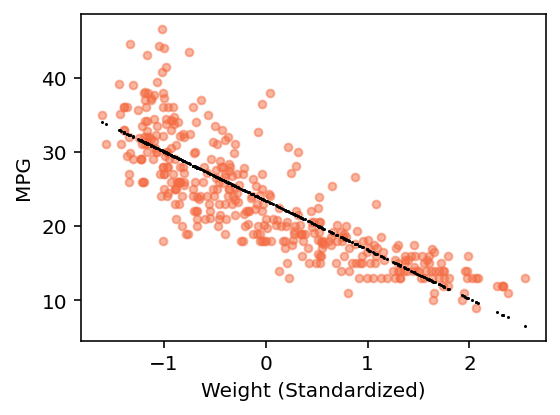

In [8]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

### With ReLU nonlinearity

Epoch    0 MSE loss      623.201 MAE    23.71
Epoch   10 MSE loss      109.012 MAE     8.23
Epoch   20 MSE loss       18.730 MAE     3.13
Epoch   30 MSE loss       23.917 MAE     3.79
Epoch   40 MSE loss       19.950 MAE     3.46
Epoch   50 MSE loss       19.357 MAE     3.25
Epoch   60 MSE loss       18.431 MAE     3.24
Epoch   70 MSE loss       18.414 MAE     3.26
Epoch   80 MSE loss       18.289 MAE     3.20
Epoch   90 MSE loss       18.162 MAE     3.21
Epoch  100 MSE loss       18.055 MAE     3.18
LAST       MSE loss       18.055 MAE     3.18


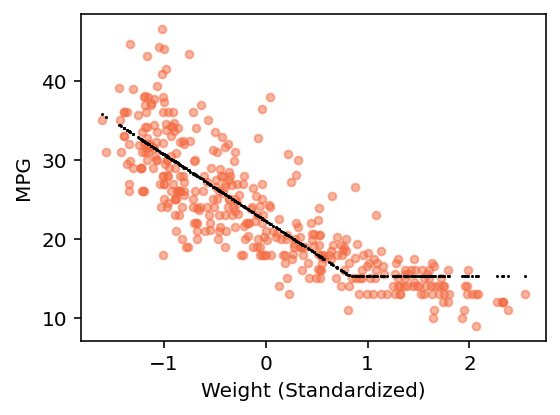

In [9]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

Epoch    0 MSE loss      581.798 MAE    22.79
Epoch   10 MSE loss       38.549 MAE     4.65
Epoch   20 MSE loss       34.832 MAE     4.53
Epoch   30 MSE loss       22.246 MAE     3.47
Epoch   40 MSE loss       17.484 MAE     3.05
Epoch   50 MSE loss       17.570 MAE     3.12
Epoch   60 MSE loss       17.459 MAE     3.11
Epoch   70 MSE loss       17.370 MAE     3.08
Epoch   80 MSE loss       17.355 MAE     3.06
Epoch   90 MSE loss       17.348 MAE     3.05
Epoch  100 MSE loss       17.347 MAE     3.05
LAST       MSE loss       17.347 MAE     3.05


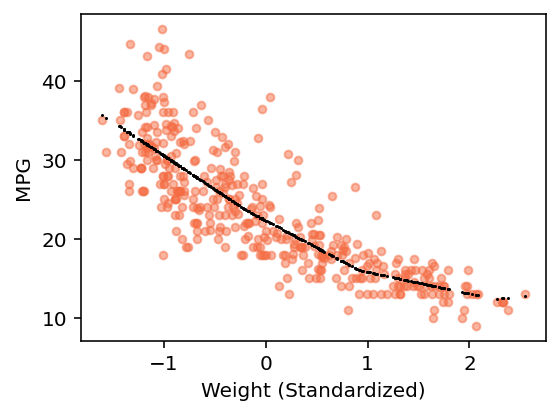

In [10]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

Epoch    0 MSE loss      588.262 MAE    22.95
Epoch   10 MSE loss      333.411 MAE    16.97
Epoch   20 MSE loss       67.779 MAE     6.81
Epoch   30 MSE loss       22.289 MAE     3.30
Epoch   40 MSE loss       22.908 MAE     3.40
Epoch   50 MSE loss       20.934 MAE     3.56
Epoch   60 MSE loss       19.134 MAE     3.19
Epoch   70 MSE loss       17.990 MAE     3.21
Epoch   80 MSE loss       17.619 MAE     3.06
Epoch   90 MSE loss       17.503 MAE     3.09
Epoch  100 MSE loss       17.464 MAE     3.07
LAST       MSE loss       17.464 MAE     3.07


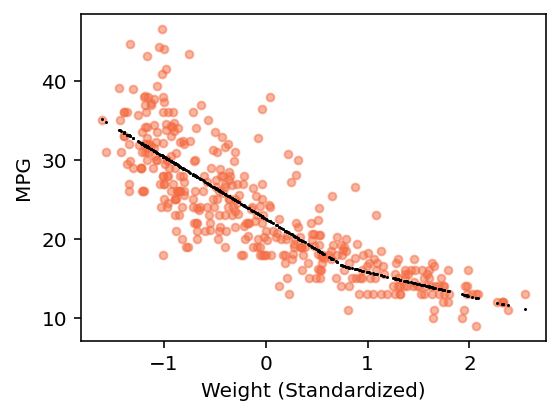

In [11]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

train(model, learning_rate=.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")

### What matrix algebra is that model doing?

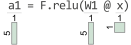

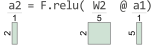

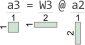

In [12]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor

W1 = torch.rand(5,1)
W2 = torch.rand(2,5)
W3 = torch.rand(1,2)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      637.803 MAE    24.00
Epoch   10 MSE loss      156.835 MAE    10.78
Epoch   20 MSE loss       67.526 MAE     6.96
Epoch   30 MSE loss       63.438 MAE     6.54
Epoch   40 MSE loss       69.113 MAE     6.67
Epoch   50 MSE loss       60.920 MAE     6.53
Epoch   60 MSE loss       61.913 MAE     6.65
Epoch   70 MSE loss       60.973 MAE     6.52
Epoch   80 MSE loss       60.771 MAE     6.55
Epoch   90 MSE loss       60.763 MAE     6.55
Epoch  100 MSE loss       60.763 MAE     6.55
LAST       MSE loss       60.763 MAE     6.55


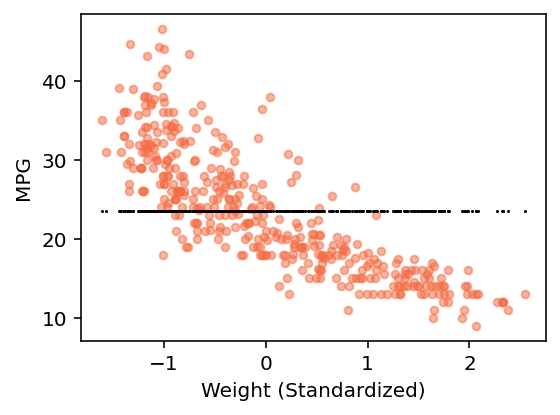

In [13]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=50, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      600.344 MAE    23.24
Epoch  200 MSE loss       17.107 MAE     3.04
Epoch  400 MSE loss       16.922 MAE     3.03
Epoch  600 MSE loss       16.709 MAE     3.02
Epoch  800 MSE loss       16.648 MAE     3.02
Epoch 1000 MSE loss       16.590 MAE     3.02
Epoch 1200 MSE loss       16.683 MAE     2.96
Epoch 1400 MSE loss       16.544 MAE     3.00
Epoch 1600 MSE loss       16.525 MAE     2.98
Epoch 1800 MSE loss       16.621 MAE     2.96
Epoch 2000 MSE loss       16.862 MAE     2.95
LAST       MSE loss       16.862 MAE     2.95


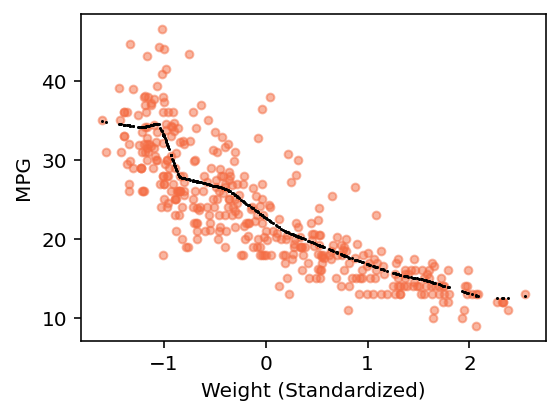

In [14]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

Epoch    0 MSE loss      615.631 MAE    23.51
Epoch  150 MSE loss       17.544 MAE     3.11
Epoch  300 MSE loss       17.265 MAE     3.05
Epoch  450 MSE loss       17.242 MAE     3.05
Epoch  600 MSE loss       17.138 MAE     3.03
Epoch  750 MSE loss       17.034 MAE     3.01
Epoch  900 MSE loss       16.960 MAE     3.01
Epoch 1050 MSE loss       16.934 MAE     3.01
Epoch 1200 MSE loss       16.873 MAE     3.00
Epoch 1350 MSE loss       16.814 MAE     3.00
Epoch 1500 MSE loss       16.970 MAE     3.07
LAST       MSE loss       16.970 MAE     3.07


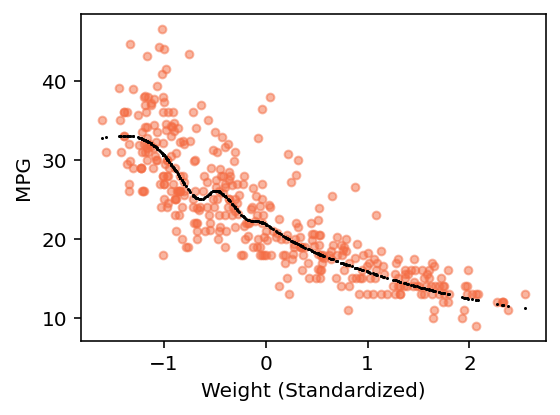

In [15]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1500)

mshow(model, X=X, y=df_cars.MPG)